# **Descripción del proyecto: Sweet Lift Taxi Pronóstico de pedidos por hora**

En este proyecto construiremos un modelo de regresión para **predecir la cantidad de pedidos de taxi para la próxima hora** en aeropuertos, usando datos históricos de la empresa **Sweet Lift Taxi**.
El desempeño del modelo se evaluará con la métrica **RECM (RMSE)** y el objetivo es obtener **RECM ≤ 48** en el conjunto de prueba.

**Flujo de trabajo que seguiré:**

* Cargar y preparar los datos, asegurando un índice temporal correcto.
* Remuestrear la serie para obtener el número de pedidos **por hora**.
* Explorar la serie temporal para identificar patrones, tendencia y estacionalidad.
* Crear características (features) basadas en:

  * calendario (año, mes, día, hora, día de la semana),
  * desfases (lags) de la serie,
  * estadísticas móviles (medias/otras).
* Dividir los datos en conjuntos de entrenamiento y prueba respetando el orden temporal.
* Entrenar y comparar varios modelos de regresión (baselines, modelos lineales y modelos de árboles/boosting).
* Seleccionar el mejor modelo según RECM en validación.
* Evaluar el modelo final en el conjunto de prueba y verificar si cumple **RECM ≤ 48**.
* Presentar conclusiones sobre la calidad del pronóstico y recomendaciones para el negocio.


# **Importación de librerías**

In [28]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from typing import Tuple, Dict, Union
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import clone
from xgboost import XGBRegressor
# Set plot styles
sns.set_theme(context='notebook', style="darkgrid", palette='deep', font='sans-serif', font_scale=1.2)

# Random seed for reproducibility
RANDOM_STATE = 12345

# Extra settings
pd.set_option('display.max_columns', None)

# **Carga y preparación de datos**

In [2]:
# Load dataset
data = pd.read_csv('../data/taxi.csv', index_col= [0], parse_dates= [0])

In [3]:
# Prepare data
data = data.sort_index()
display(data.info(), data.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# Check dates range and if its monotonic increasing
print(f"Date range: {data.index.min()} to {data.index.max()}")
print(f"Is index monotonic increasing? {data.index.is_monotonic_increasing}")

Date range: 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Is index monotonic increasing? True


In [5]:
# Check for missing values and duplicates
print(f"Missing values:\n{data.isnull().sum()}")
print(f"Duplicate rows: {data.index.duplicated().sum()}")

Missing values:
num_orders    0
dtype: int64
Duplicate rows: 0


In [6]:
# Resample data to hourly frequency, summing up the orders
data = data.resample('h').sum()
data


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


# **Exploración de datos rápida**

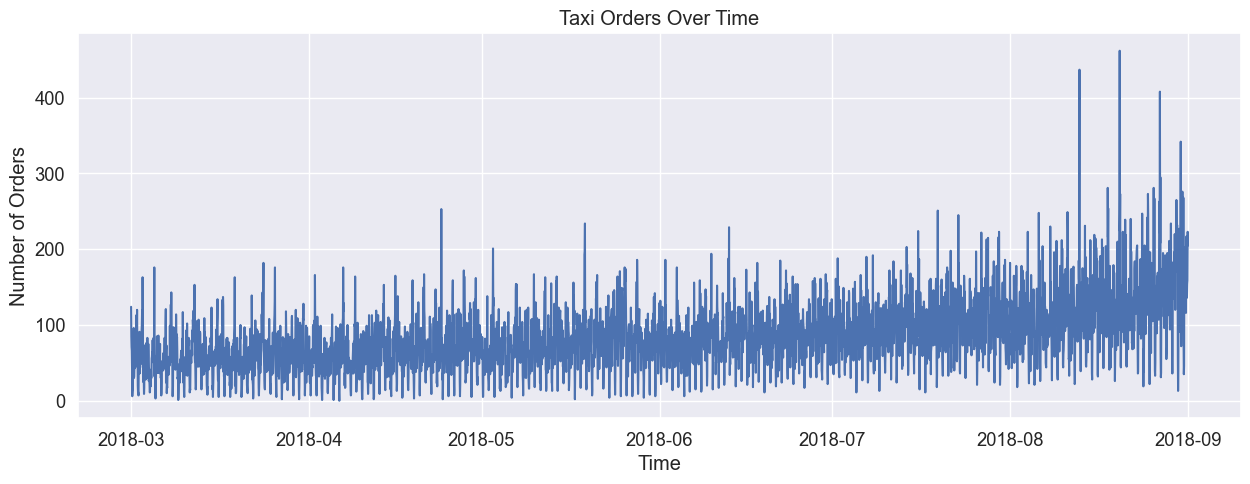

In [7]:
# Quick data exploration
plt.figure(figsize=(15, 5))
sns.lineplot(data=data, x=data.index, y='num_orders')
plt.title('Taxi Orders Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.show()

In [8]:
# Create temporal features for EDA purposes
eda_df = data.copy()
eda_df['hour'] = eda_df.index.hour
eda_df['day_of_week'] = eda_df.index.dayofweek
eda_df['month'] = eda_df.index.month

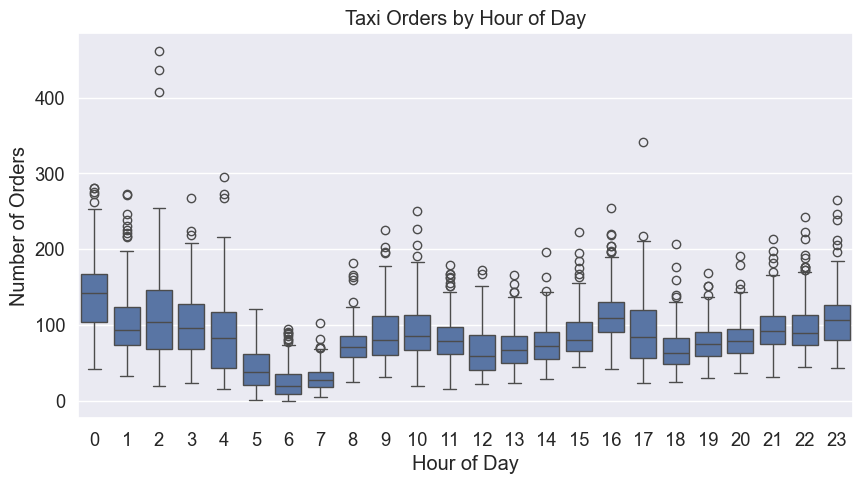

In [9]:
# Orders by hour of day
plt.figure(figsize=(10, 5))
sns.boxplot(x='hour', y='num_orders', data=eda_df)
plt.title('Taxi Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.show()

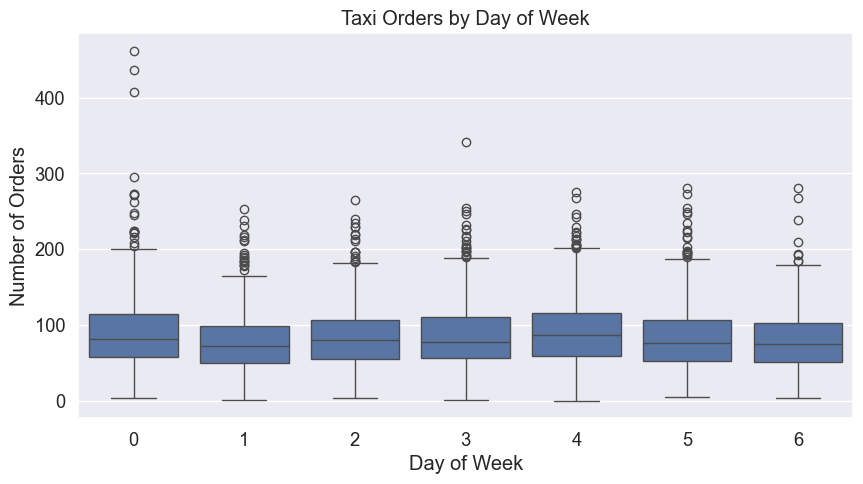

In [10]:
# Orders by day of week
plt.figure(figsize=(10, 5))
sns.boxplot(x='day_of_week', y='num_orders', data=eda_df)
plt.title('Taxi Orders by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.show()

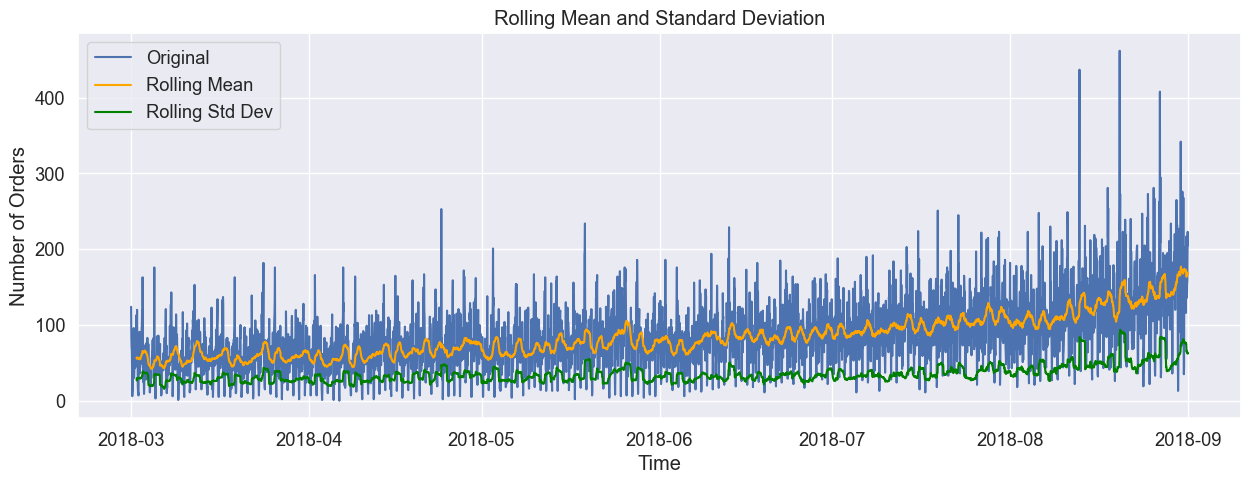

In [11]:
# Rolling mean and std deviation
rolling_window = 24  # 24 hours
rolling_mean = data['num_orders'].rolling(window=rolling_window).mean()
rolling_std = data['num_orders'].rolling(window=rolling_window).std()
# Plot rolling statistics
plt.figure(figsize=(15, 5))
sns.lineplot(data=data, x=data.index, y='num_orders', label='Original')
sns.lineplot(x=data.index, y=rolling_mean, label='Rolling Mean', color='orange')
sns.lineplot(x=data.index, y=rolling_std, label='Rolling Std Dev', color='green')
plt.title('Rolling Mean and Standard Deviation')
plt.xlabel('Time')
plt.ylabel('Number of Orders')
plt.show()

In [12]:
# Trend, seasonality, and residuals decomposition
decomposition = seasonal_decompose(data['num_orders'], model='additive', period=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


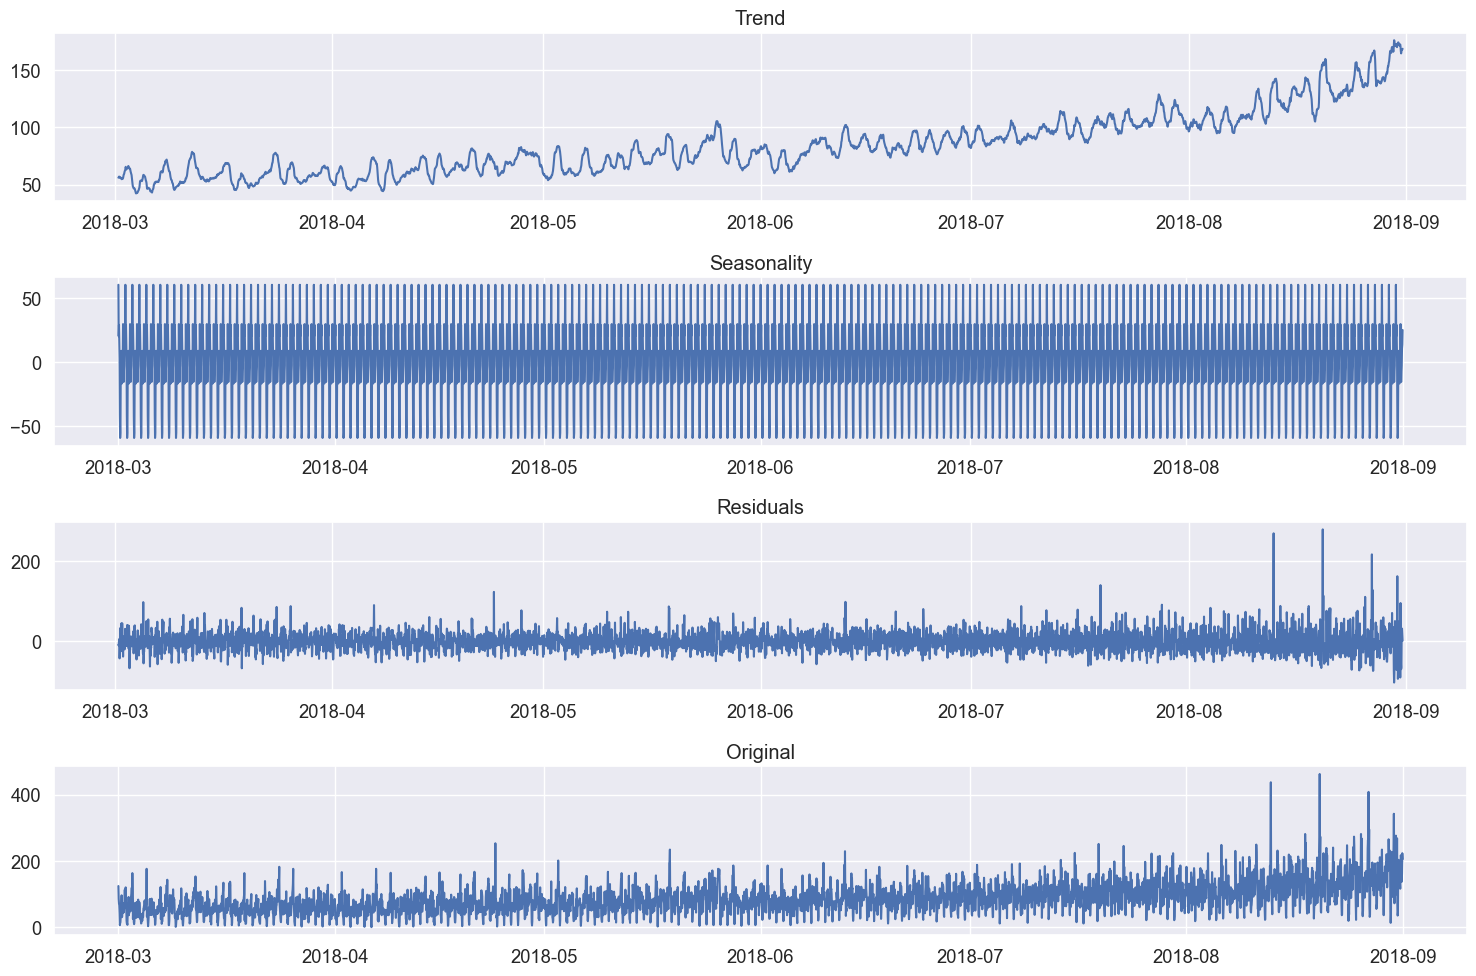

In [13]:
# Plot decomposition results
plt.figure(figsize=(15, 10))
plt.subplot(4, 1, 1)
plt.plot(trend)
plt.title('Trend')
plt.subplot(4, 1, 2)
plt.plot(seasonal)
plt.title('Seasonality')
plt.subplot(4, 1, 3)
plt.plot(residual)
plt.title('Residuals')
plt.subplot(4, 1, 4)
plt.plot(data['num_orders'])
plt.title('Original')
plt.tight_layout()
plt.show()

## **Observaciones clave del análisis exploratorio**

* **Tendencia general**

  * La demanda de taxis por hora **aumenta de forma sostenida** de marzo a agosto de 2018.
  * También crece la **variabilidad**: hacia el final del periodo hay más picos muy altos → el proceso no es estacionario.

* **Patrones por hora del día**

  * Horas con **mayor demanda**: principalmente de **tarde y noche (16:00–23:00)**, con muchos picos extremos.
  * Horas con **menor demanda**: madrugada y primeras horas de la mañana (**4:00–6:00**).
  * La planificación de conductores debe enfocarse mucho más en el **patrón intradía** que en otros factores.

* **Patrones por día de la semana**

  * Los niveles de demanda son **similares de lunes a domingo**; no hay diferencias tan marcadas como por hora del día.
  * El día de la semana tiene efecto, pero **menos relevante** que la hora.

* **Media móvil, desviación estándar y descomposición**

  * La **media móvil** confirma la tendencia creciente.
  * La **desviación estándar móvil** crece con el tiempo, indicando mayor volatilidad.
  * La descomposición muestra:

    * una tendencia clara,
    * una **estacionalidad diaria fuerte** (ciclos que se repiten cada día),
    * residuos sin estructura evidente.

* **Conclusión para el modelo**

  * El comportamiento de la serie está dominado por:
    **tendencia + patrón diario + valores recientes**.
  * El modelo de pronóstico deberá aprovechar:

    * características de calendario (hora, día de la semana, mes),
    * lags de la serie,
    * estadísticas móviles (por ejemplo, medias de las últimas horas),
      para anticipar correctamente las horas pico y apoyar la planificación de conductores.


# **Crear características temporales**

In [14]:
# Function to create temporal features
def make_features(df : pd.DataFrame, max_lag: int, rolling_window_size: int | list[int]) -> pd.DataFrame:
    """
    Create temporal features from datetime index.
    
    Parameters:
    df (pd.DataFrame): Input dataframe with datetime index.
    max_lag (int): Maximum number of lag features to create.
    rolling_window_size (int | list[int]): Window size for rolling statistics.
    
    Returns:
    pd.DataFrame: Dataframe with added temporal features.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['week_of_year'] = df.index.isocalendar().week
    
    
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
    
    for window in (rolling_window_size if isinstance(rolling_window_size, list) else [rolling_window_size]):
        df[f'rolling_mean_{window}'] = df['num_orders'].shift(1).rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['num_orders'].shift(1).rolling(window=window).std()
    
    df = df.dropna()
    return df


In [15]:
# Generate features
feature_df = make_features(data, max_lag=24, rolling_window_size=[24,48])

# Display the feature dataframe
display(feature_df.head(), feature_df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4368 entries, 2018-03-03 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   num_orders       4368 non-null   int64  
 1   hour             4368 non-null   int32  
 2   day_of_week      4368 non-null   int32  
 3   month            4368 non-null   int32  
 4   week_of_year     4368 non-null   UInt32 
 5   lag_1            4368 non-null   float64
 6   lag_2            4368 non-null   float64
 7   lag_3            4368 non-null   float64
 8   lag_4            4368 non-null   float64
 9   lag_5            4368 non-null   float64
 10  lag_6            4368 non-null   float64
 11  lag_7            4368 non-null   float64
 12  lag_8            4368 non-null   float64
 13  lag_9            4368 non-null   float64
 14  lag_10           4368 non-null   float64
 15  lag_11           4368 non-null   float64
 16  lag_12          

,num_orders,hour,day_of_week,month,week_of_year,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_24,rolling_std_24,rolling_mean_48,rolling_std_48
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-03 00:00:00,163,0,5,3,9,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,62.750000,32.715174,59.791667,30.918533
2018-03-03 01:00:00,108,1,5,3,9,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,65.791667,38.279270,60.604167,33.078720
2018-03-03 02:00:00,25,2,5,3,9,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,65.291667,37.612994,61.083333,33.602073
2018-03-03 03:00:00,64,3,5,3,9,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,63.208333,38.427774,60.125000,33.967209
2018-03-03 04:00:00,44,4,5,3,9,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,83.0,82.0,59.0,44.0,45.0,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,63.208333,38.427774,60.083333,33.961075


None

# **Dividir los datos en conjuntos de entrenamiento y prueba**

In [16]:
# Split data into training and testing sets
X = feature_df.drop(columns=['num_orders'])
y = feature_df['num_orders']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

print(f"Training X size: {X_train.shape}, Testing X size: {X_test.shape}")
print(f'Train y size: {y_train.shape[0]} samples, test y size: {y_test.shape[0]} samples')
print(f"Training period: {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing period: {X_test.index.min()} to {X_test.index.max()}")

Training X size: (3931, 32), Testing X size: (437, 32)
Train y size: 3931 samples, test y size: 437 samples
Training period: 2018-03-03 00:00:00 to 2018-08-13 18:00:00
Testing period: 2018-08-13 19:00:00 to 2018-08-31 23:00:00


# **Entrenar y comparar varios modelos de regresión (baselines, modelos lineales y modelos de árboles/boosting).**
1. Baselines:
   * Naive last value
   * Media/mediana de últimas 24 horas
2. Modelos:

   * LinearRegression
   * Ridge
   * RandomForestRegressor
   * GradientBoostingRegressor
   * XGBRegressor (experimental)



In [17]:
# Function to evaluate model performance
ModelTypes = Union[RandomForestRegressor, GradientBoostingRegressor, LinearRegression, RidgeCV, Pipeline]
def evaluate_model(model_name : str , estimator: ModelTypes, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, verbose: bool = False) -> Tuple[dict, ModelTypes]:
    
    '''
    Function to train and evaluate the model using RMSE metric.
    
    Parameters:
        model_name (str): Name of the model.
        estimator: The model instance to be trained and evaluated.
        X_train, y_train: Training data.
        X_test, y_test: Testing data.
        verbose (bool): If True, prints detailed evaluation metrics.
    
    Returns:
    Tuple[dict, ModelTypes]: A tuple containing a dictionary of evaluation metrics and the trained model.
    
    '''
    results = {'name': model_name}
    model = clone(estimator)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_rmse = root_mean_squared_error(y_train, y_train_pred)
    test_rmse = root_mean_squared_error(y_test, y_test_pred)
    results['RMSE_train'] = train_rmse
    results['RMSE_test'] = test_rmse
    if verbose:
        print(f"{model_name} - Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    return results, model

# List of results
results_list = []

In [18]:
# Baseline evaluation
# Naive last value forecast
y_pred_naive_train = X_train['lag_1']
y_pred_naive_test = X_test['lag_1']
naive_rmse_train = root_mean_squared_error(y_train, y_pred_naive_train)
naive_rmse_test = root_mean_squared_error(y_test, y_pred_naive_test)
results_list.append({
    'name': 'Naive Forecast - Baseline',
    'RMSE_train': naive_rmse_train,
    'RMSE_test': naive_rmse_test
})

print(f"Naive Forecast - Train RMSE: {naive_rmse_train:.4f}, Test RMSE: {naive_rmse_test:.4f}")

# Rolling mean forecast
y_pred_rolling_train = X_train['rolling_mean_24']
y_pred_rolling_test = X_test['rolling_mean_24']
rolling_rmse_train = root_mean_squared_error(y_train, y_pred_rolling_train)
rolling_rmse_test = root_mean_squared_error(y_test, y_pred_rolling_test)
results_list.append({
    'name': 'Rolling Mean Forecast - Baseline',
    'RMSE_train': rolling_rmse_train,
    'RMSE_test': rolling_rmse_test
})

print(f"Rolling Mean Forecast - Train RMSE: {rolling_rmse_train:.4f}, Test RMSE: {rolling_rmse_test:.4f}")

Naive Forecast - Train RMSE: 36.2359, Test RMSE: 59.0190
Rolling Mean Forecast - Train RMSE: 34.5547, Test RMSE: 58.0376


In [19]:
# Create TimeSeriesSplit object for cross-validation
tscv = TimeSeriesSplit(n_splits=3)

# Pipelines for Linear models
linear_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=tscv))
])

In [20]:
# Linear models evaluation
# Train and evaluate Linear Regression
lr_results, lr_model = evaluate_model('Linear Regression', linear_pipeline, verbose=True)
results_list.append(lr_results)
# Train and evaluate Ridge Regression
ridge_results, ridge_model = evaluate_model('Ridge Regression', ridge_pipeline, verbose=True)
results_list.append(ridge_results)

Linear Regression - Train RMSE: 25.6802, Test RMSE: 47.1946
Ridge Regression - Train RMSE: 25.6827, Test RMSE: 46.9708


In [21]:
# Search for best hyperparameters for Forest models
# Random Forest Regressor
rf_estimator = RandomForestRegressor(random_state=RANDOM_STATE)
rf_param_grid = {
    'n_estimators': [200, 400],
    'max_depth': [8, 12, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': [1.0, 'sqrt'],
    'bootstrap': [True]
}
rf_gridSearch = GridSearchCV(estimator=rf_estimator, param_grid=rf_param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_gridSearch.fit(X_train, y_train)
best_rf_model = rf_gridSearch.best_estimator_
print(f"Best Random Forest parameters: {rf_gridSearch.best_params_}")

Best Random Forest parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}


In [23]:
# Gradient Boosting Regressor
gb_estimator = GradientBoostingRegressor(random_state=RANDOM_STATE)
gbr_param_grid = {
    'n_estimators': [200, 400],
    'learning_rate': [0.05, 0.1],
    'max_depth': [2, 3],
    'min_samples_leaf': [1, 5],
    'subsample': [0.8, 1.0],
    'max_features': [1.0, 'sqrt'],
}
gbr_gridSearch = GridSearchCV(estimator=gb_estimator, param_grid=gbr_param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
gbr_gridSearch.fit(X_train, y_train)
best_gbr_model = gbr_gridSearch.best_estimator_
print(f"Best Gradient Boosting parameters: {gbr_gridSearch.best_params_}")

Best Gradient Boosting parameters: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 1.0, 'min_samples_leaf': 5, 'n_estimators': 400, 'subsample': 0.8}


In [24]:
# Train and evaluate RandomForestRegressor
rf_results, rf_model = evaluate_model('Random Forest Regressor', best_rf_model, verbose=True)
results_list.append(rf_results)

Random Forest Regressor - Train RMSE: 8.3747, Test RMSE: 43.3118


In [25]:
# Train and evaluate GradientBoostingRegressor
gbr_results, gbr_model = evaluate_model('Gradient Boosting Regressor', best_gbr_model, verbose=True)
results_list.append(gbr_results)

Gradient Boosting Regressor - Train RMSE: 17.1476, Test RMSE: 39.5650


In [ ]:
# Experimental using XGBoost Regressor 
# XGBoost Regressor could be slightly faster than Gradient Boosting Regressor but since this is not big data it won't reflect it's best advantages
xgb = XGBRegressor(
    objective='reg:squarederror',
    tree_method='hist',         
    eval_metric='rmse',
    random_state=RANDOM_STATE
)
xgb_param_grid = {
    'n_estimators': [300, 600],
    'learning_rate': [0.03, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'min_child_weight': [1, 5]
}
xgb_gridSearch = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1)
xgb_gridSearch.fit(X_train, y_train)
best_xgb_model = xgb_gridSearch.best_estimator_
print(f"Best XGBoost parameters: {xgb_gridSearch.best_params_}")

Best XGBoost parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 600, 'subsample': 0.7}


In [31]:
# Train and evaluete XGBoost Regressor
xgb_results, xgb_model = evaluate_model('XGBoost Regressor', best_xgb_model, verbose=True)
results_list.append(xgb_results)

XGBoost Regressor - Train RMSE: 15.5618, Test RMSE: 41.2232


# **Seleccionar el mejor modelo según RECM en validación.**


In [32]:
# Dataframe with the results
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='RMSE_test').reset_index(drop=True)
results_df.set_index('name', inplace=True)
results_df

,RMSE_train,RMSE_test
name,,
Gradient Boosting Regressor,17.147632,39.565015
XGBoost Regressor,15.561802,41.223164
Random Forest Regressor,8.374713,43.311829
Ridge Regression,25.682668,46.970788
Linear Regression,25.680209,47.194568
Rolling Mean Forecast - Baseline,34.554692,58.037562
Naive Forecast - Baseline,36.235865,59.019040


## **Selección del modelo final**

Tras el ajuste de hiperparámetros con validación cruzada temporal, los modelos basados en boosting (Gradient Boosting y XGBoost) superan claramente tanto a los baselines ingenuos como a los modelos lineales y al Random Forest.
El mejor desempeño se obtuvo con Gradient Boosting Regressor, con un RMSE ≈ 39.6 en el conjunto de prueba, seguido por XGBoost (≈ 41.2) y Random Forest (≈ 43.3). Todos ellos cumplen el criterio del proyecto (RMSE ≤ 48), pero el modelo seleccionado para el pronóstico final es Gradient Boosting por ofrecer el menor error en datos no vistos.

# **Conclusión final del proyecto**

En este proyecto construimos un sistema de pronóstico para **predecir el número de pedidos de taxi por hora en aeropuertos** para Sweet Lift Taxi. El objetivo era obtener un **RMSE en el conjunto de prueba ≤ 48 pedidos/hora**; este requisito se cumplió holgadamente.

## 1. Comportamiento de la demanda

Del análisis de la serie temporal (datos por hora de marzo a agosto de 2018) encontramos que:

* Existe una **tendencia creciente**: con el paso de los meses, el nivel promedio de pedidos por hora aumenta.
* Hay una **estacionalidad diaria muy marcada**:

  * Mayor demanda en **tardes y noches (≈16:00–23:00)**.
  * Menor demanda en **madrugada y primeras horas de la mañana (≈4:00–6:00)**.
* La **variabilidad también aumenta con el tiempo**, lo que confirma que la serie es **no estacionaria**.

Estos patrones justifican el uso de características de tiempo (hora, día de la semana) y de valores recientes (lags y medias móviles) para el modelo.

## 2. Enfoque de modelado

1. Se remuestreó la serie original a **intervalos de 1 hora**.
2. Se generaron características como:

   * variables de calendario (año, mes, día, hora, día de la semana),
   * rezagos de la serie (lags),
   * medias móviles de las últimas horas.
3. Se definieron **baselines**:

   * pronóstico ingenuo (último valor),
   * promedio de las últimas 24 horas.
     Ambos obtuvieron RMSE cercanos a 58–59 pedidos/hora.
4. Se dividieron los datos respetando el orden temporal:

   * 90% para **entrenamiento + validación** (con `TimeSeriesSplit`),
   * 10% final como **conjunto de prueba** independiente.

Sobre esta base se entrenaron y compararon los siguientes modelos de regresión:

* Regresión lineal y Ridge.
* Random Forest Regressor.
* Gradient Boosting Regressor.
* XGBoost Regressor.

A todos se les ajustaron hiperparámetros mediante **GridSearchCV** con validación cruzada temporal.

## 3. Resultados de los modelos

En el conjunto de prueba (10% final de la serie):

* **Gradient Boosting Regressor**

  * RMSE_train ≈ 17.15
  * **RMSE_test ≈ 39.56**

* **XGBoost Regressor**

  * RMSE_train ≈ 15.56
  * **RMSE_test ≈ 41.22**

* **Random Forest Regressor**

  * RMSE_train ≈ 8.37
  * **RMSE_test ≈ 43.31**

* **Ridge / Regresión lineal**

  * RMSE_test ≈ 47–47.5

Todos los modelos de aprendizaje automático superan ampliamente a los baselines (≈58–59).
El **mejor desempeño** lo obtuvo **Gradient Boosting Regressor**, con un **RMSE ≈ 39.6 pedidos/hora**, muy por debajo del umbral de 48 definido por el negocio.

## 4. Conclusión de negocio y recomendaciones

* El modelo final de **Gradient Boosting** es capaz de **predecir la demanda por hora con un error medio de ≈40 pedidos/hora**, lo que representa una mejora sustancial frente a reglas simples como “usar el último valor” o “promedio del día anterior”.
* Este nivel de precisión permite a Sweet Lift Taxi:

  * **Planificar con antelación** la cantidad de conductores necesarios en cada hora.
  * Identificar con claridad las **horas pico de operación** (tarde y noche) y ajustar los incentivos o turnos.
  * Reducir el riesgo de:

    * **sobrecapacidad** (demasiados conductores esperando sin viajes),
    * **subcapacidad** (demanda insatisfecha en horas pico).

En resumen, el proyecto demuestra que un modelo de Gradient Boosting bien diseñado y ajustado permite a Sweet Lift Taxi contar con un **sistema sólido de pronóstico de demanda por hora**, útil para la toma de decisiones operativas y la optimización de recursos.
